## Advanced Lane Finding Project
The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import package

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Calibrate camara, and read an image first

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


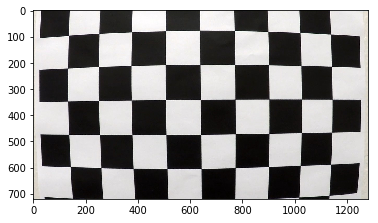

In [2]:
#reading in an image
image = mpimg.imread('camera_cal/calibration1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

It seems that each image has 9x6 cornors

## Read all calibration images and calibrate

In [3]:
import glob
images = glob.glob('./camera_cal/calibration*.jpg')

### Calibrate camera

In [4]:
# arrays to hold the object and image points
objpoints = []
imgpoints = []

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # x,y coordinates

for fname in images:
    # read an image
    img = mpimg.imread(fname)
    
    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # refer to Lesson 6, class 11 for BGR or RGB
    
    # find the chess borders
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if corners are found
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        
# calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1::-1], None, None)

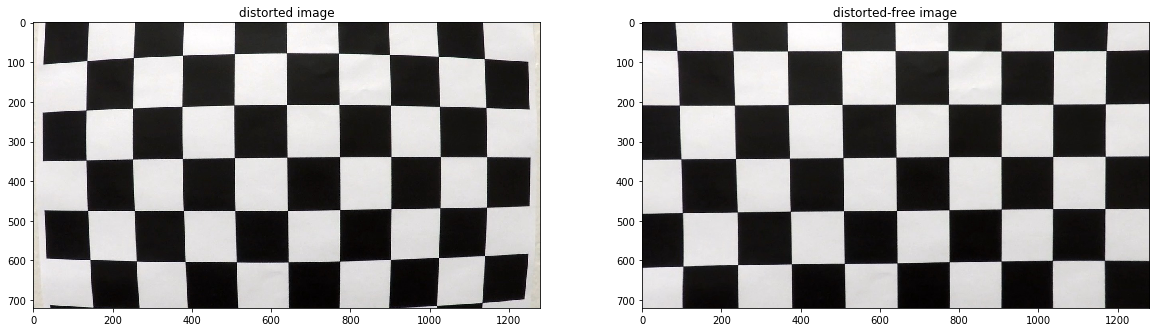

In [5]:
camera_image =  mpimg.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(camera_image, mtx, dist, None, mtx)  
plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(camera_image)
plt.title('distorted image')
plt.subplot(122), plt.imshow(dst)
plt.title('distorted-free image')

mpimg.imsave('./output_images/distorted_free_calibration1.jpg', dst)

### Helper functions

In [6]:
def show_imgs(original_img, processed_img):
    plt.figure(figsize=(20,10))
    plt.subplot(121),plt.imshow(original_img)
    plt.title('Original Image')
    plt.subplot(122),plt.imshow(processed_img, cmap='gray')
    plt.title('Processed Image')
    plt.show()

def warper(img):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    
    # perspective transformation, magic numbers, using undistorted straight_lines2.jpg
    src = np.float32([[250,700], [430,570], [870, 570], [1065, 700]])
    dst = np.float32([[300,img.shape[0]], [300, 620], [900, 620], [900, img.shape[0]]])
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped   

def unwarper(img):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    
    # perspective transformation, magic numbers, using undistorted straight_lines2.jpg
    dst = np.float32([[250,700], [430,570], [870, 570], [1065, 700]])
    src = np.float32([[300,img.shape[0]], [300, 620], [900, 620], [900, img.shape[0]]])

    
    Minv = cv2.getPerspectiveTransform(src, dst)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return unwarped

def find_lane_pixels(binary_warped, find_line_paras):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint]) 
    rightx_base = np.argmax(histogram[midpoint:binary_warped.shape[1]]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = find_line_paras[0]
    # Set the width of the windows +/- margin
    margin = find_line_paras[1]
    # Set minimum number of pixels found to recenter window
    minpix = find_line_paras[2]

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    shift_left = 0 # shift with previous window
    count_shift_left = 0 # count consecutive windows where if condition is not met
    shift_right = 0
    count_shift_right = 0
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###

        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high) & \
            (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox <= win_xright_high) & \
            (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If  found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            shift_left = np.int(np.mean(nonzerox[good_left_inds])) - leftx_current
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            count_shift_left = 0
        #else: # which indicates that there is a big curve, try to maintain the same shift with previous
        ##    leftx_current =  np.int(leftx_current + shift_left*(1+count_shift_left*0.7))
            count_shift_left +=1
            
        if len(good_right_inds) > minpix:
            shift_right = np.int(np.mean(nonzerox[good_right_inds])) - rightx_current
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            count_shift_right = 0
        #else:
        #    rightx_current = np.int(rightx_current + shift_right*(1+count_shift_right*0.7))
        #    count_shift_right +=1
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def process_warped(dst, left_fitx, right_fitx, ploty):
    # Add lines and ploygons for the warped image: green as polygon, red for left and blue for right boundary 
    warped = np.zeros_like(dst)
    draw_points_left= np.array([np.transpose(np.vstack([left_fitx, ploty]))]).astype(np.int32)
    draw_points_right= np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]).astype(np.int32) # flip to fillpoly
    pts = np.hstack((draw_points_left, draw_points_right))
    cv2.fillPoly(warped, [pts], (0, 255, 0))
    cv2.polylines(warped, [draw_points_left], False, (255,0,0) ,20)  # args: image, points, closed, color, thickness
    cv2.polylines(warped, [draw_points_right], False, (0,0,255) ,20)
    return warped

def conversion_to_world_space(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    ### Fit a second order polynomial to each using `np.polyfit` ###， in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,deg=2)
    right_fit_cr = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,deg=2)
    
    # measure curvature in world space
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])  
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    # vehicle position respect to center
    try:
        x_left_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        x_right_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        x_left_eval = 1**y_eval**2 + 1**y_eval
        x_right_eval = 1**y_eval**2 + 1**y_eval
    center = (x_left_eval + x_right_eval)//2
    shift = center - binary_warped.shape[1]/2
    shift_cr = round(shift*xm_per_pix, 2)
    
    curverad = (left_curverad + right_curverad)//2
    msg1 = "Radius of Curvature = " + str(curverad) + "(m)"
    
    if shift_cr > 0 :
        msg2 = "Vehicle is " + str(shift_cr) + "m left of center"
    elif shift_cr == 0:
        msg2 = "Vehicle is at the center of the line!"
    else:
        msg2 = "Vehicle is "+ str(-shift_cr) + "m right of center"
    
    return msg1, msg2
       

def write_text(unwarped, msg1, msg2):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText1 = (100,100)
    bottomLeftCornerOfText2 = (100,160)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 2
    
    cv2.putText(unwarped, msg1, bottomLeftCornerOfText1, font, fontScale, fontColor, lineType)
    cv2.putText(unwarped, msg2, bottomLeftCornerOfText2, font, fontScale, fontColor, lineType)
    
    return unwarped
    

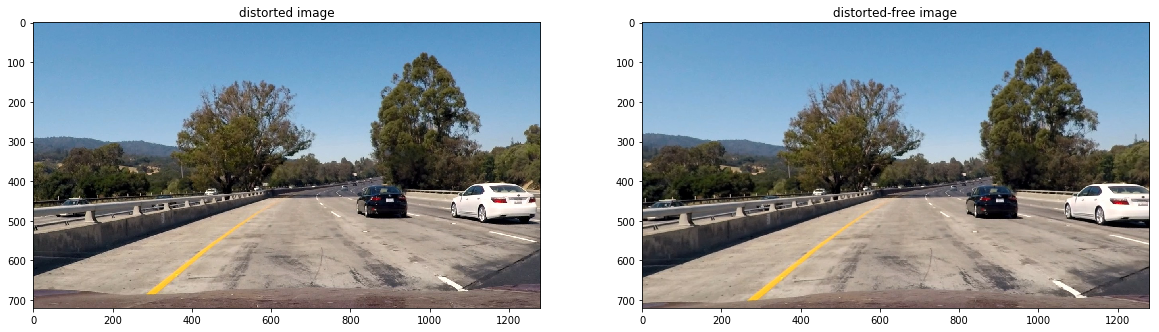

In [7]:
test_image =  mpimg.imread('./test_images/test1.jpg')

dst = cv2.undistort(test_image, mtx, dist, None, mtx)  

plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(test_image)
plt.title('distorted image')
plt.subplot(122), plt.imshow(dst)
plt.title('distorted-free image')

mpimg.imsave('./output_images/distorted_free_test1.jpg', dst)

### Key function to apply different channel filters for detection

In [8]:
def binary_warper(image_name, visualization = False):
    # undistort the image
    if isinstance(image_name, str):
        image_name= mpimg.imread(image_name)
    image = np.copy(image_name)
    dst = cv2.undistort(image, mtx, dist, None, mtx)    
    
    #dst = cv2.GaussianBlur(dst, (3,3), 0)
        
    # After so many trials of threshold parameters, it seems that it is not enough by only using HLS-S channel and Sobel x
    
    # more to added as: 1. Using RGB scale to select the range for white lines and yellow lines
    # 2. also using HSV - S channel, as suggested in the class materials
    
    colors = {
    'yellow': {
        'min': np.array([150, 150, 0]),
        'max': np.array([255, 255, 120])
    },
    'white': {
        'min': np.array([185, 185, 185]),
        'max': np.array([255, 255, 255])
    }
    }
    
    gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
    gray_binary = np.zeros_like(gray)
    #gray_binary[(gray > gray_thresh[0]) & (gray <= gray_thresh[1])] = 1
    
    if visualization:
        plt.figure(figsize=(20,10))
        plt.subplot(121),plt.imshow(gray)
        plt.title('gray')  
        plt.subplot(122),plt.imshow(gray_binary, cmap='gray')
        plt.title('gray_binary')  
        
        
    yellow_thresh_img = cv2.inRange(dst, colors['yellow']['min'], colors['yellow']['max'])
    white_thresh_img = cv2.inRange(dst, colors['white']['min'], colors['white']['max'])
    if visualization:
        plt.figure(figsize=(15,10))
        plt.subplot(131),plt.imshow(image)
        plt.subplot(132), plt.imshow(yellow_thresh_img)
        plt.title('yellow')        
        plt.subplot(133), plt.imshow(white_thresh_img)   
        plt.title('white')
    

    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    hls_s_channel = hls[:,:,2]
    hls_h_channel = hls[:,:,0]
    
    if visualization:
        plt.figure(figsize=(15,10))
        plt.subplot(131),plt.imshow(image)
        plt.subplot(132),plt.imshow(hls_s_channel)
        plt.title('HLS:S channel')
        plt.subplot(133),plt.imshow(hls_h_channel)
        plt.title('HLS:H channel')
 

    # Convert to HSV color space and separate the S channel
    hsv = cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)
    hsv_s_channel = hls[:,:,1]
    hsv_h_channel = hls[:,:,0]
    
    if visualization:
        plt.figure(figsize=(15,10))
        plt.subplot(131),plt.imshow(image)
        plt.subplot(132),plt.imshow(hsv_s_channel)
        plt.title('HSV:S channel')
        plt.subplot(133),plt.imshow(hsv_h_channel)
        plt.title('HSV:H channel')
    
    R = dst[:,:,0]
    G = dst[:,:,1]
    B = dst[:,:,2]
    
    if visualization:
        plt.figure(figsize=(15,10))
        plt.subplot(131),plt.imshow(R)
        plt.title('R channel')
        plt.subplot(132),plt.imshow(G)
        plt.title('G channel')
        plt.subplot(133),plt.imshow(B)
        plt.title('B channel')

    # Sobel x
    #sobelx = cv2.Sobel(B, cv2.CV_64F, 1, 0, ksize = 3) # Take the derivative in x 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = grad_thresh[0]
    thresh_max = grad_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold HLS-S channel
    s_thresh_min = hls_thresh[0]
    s_thresh_max = hls_thresh[1]
    hls_s_binary = np.zeros_like(hls_s_channel)
    hls_s_binary[(hls_s_channel >= s_thresh_min) & (hls_s_channel <= s_thresh_max)] = 1

    #Threshold HSV-S channel
    s_thresh_min = hsv_thresh[0]
    s_thresh_max = hsv_thresh[1]
    hsv_s_binary = np.zeros_like(hsv_s_channel)
    hsv_s_binary[(hsv_s_channel >= s_thresh_min) & (hsv_s_channel <= s_thresh_max)] = 1
    
    # Apply the threshold on the yellow mask
    yellow_binary = (yellow_thresh_img // 255).astype(np.uint8)

    # Apply the threshold on the white mask
    white_binary = (white_thresh_img // 255).astype(np.uint8)
    
    
    # combine 
    combined_binary = np.zeros_like(hsv_s_binary)
    combined_binary[(sxbinary == 1) | (hls_s_binary == 1) | (hsv_s_binary ==1)| (yellow_binary ==1)| (white_binary ==1)] = 1
    
    # add region of interest
    
    vertices = np.array([[130, combined_binary.shape[0]], 
                     [625, combined_binary.shape[0]*0.6], 
                     [700, combined_binary.shape[0]*0.6], 
                     [1200, combined_binary.shape[0]]], np.int32)

    #defining a blank mask to start with
    mask = np.zeros_like(combined_binary)   
    ignore_mask_color = 1

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, np.int32([vertices]), ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    combined_binary = cv2.bitwise_and(combined_binary, mask)
    
    #plt.imshow(combined_binary, cmap='gray')
    #mpimg.imsave("./output_images/binary_image", combined_binary)
    
    
    binary_warped = warper(combined_binary)
    return dst, binary_warped

In [9]:
grad_thresh = [40,100]
gray_thresh = [170,170] # not used
hls_thresh = [170, 200]  # lower threshold could not be too low, otherwise wall  will be detected
hsv_thresh = [210,205] # hsv space not used; lower threshold could not be too low, or the road background will be detected;

# number of sliding windows, the width of the windows +/- margin, minimum number of pixels found to recenter window
find_line_paras = [9, 100, 50] 

In [10]:
binary_warper(test_image)   #enable the plot in cell 8 to save the example output binary image

(array([[[ 96, 154, 200],
         [ 96, 154, 200],
         [ 96, 154, 200],
         ..., 
         [ 86, 148, 195],
         [ 85, 147, 194],
         [ 86, 148, 195]],
 
        [[ 97, 153, 200],
         [ 97, 153, 200],
         [ 97, 153, 200],
         ..., 
         [ 86, 148, 195],
         [ 85, 147, 194],
         [ 86, 148, 195]],
 
        [[ 98, 154, 201],
         [ 98, 154, 201],
         [ 98, 154, 201],
         ..., 
         [ 86, 148, 195],
         [ 86, 148, 195],
         [ 86, 148, 195]],
 
        ..., 
        [[106,  92, 104],
         [107,  92, 104],
         [107,  92, 104],
         ..., 
         [124, 105,  98],
         [123, 104,  97],
         [122, 103,  96]],
 
        [[111,  95, 106],
         [111,  95, 106],
         [111,  94, 105],
         ..., 
         [126, 107, 100],
         [125, 107, 100],
         [125, 107, 100]],
 
        [[113,  96, 106],
         [112,  95, 104],
         [110,  93, 102],
         ..., 
         [127, 110, 103

### Test perspective transformation

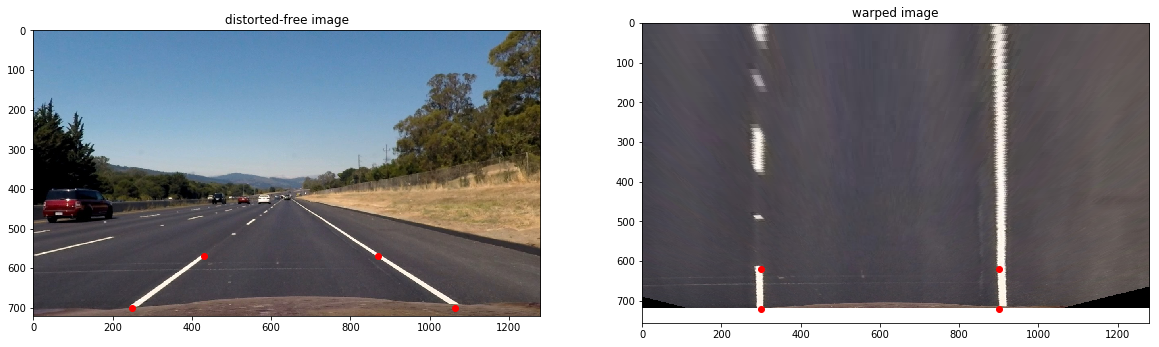

In [11]:
test_image2 = mpimg.imread('./test_images/straight_lines2.jpg')
dst = cv2.undistort(test_image2, mtx, dist, None, mtx)

warped = warper(dst)

plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(dst)
plt.plot(250, 700,'ro')
plt.plot(430, 570, 'ro')
plt.plot(870, 570, 'ro')
plt.plot(1065, 700, 'ro')
plt.title('distorted-free image')
plt.subplot(122), plt.imshow(warped)
plt.title('warped image')
plt.plot(300, 720,'ro')
plt.plot(300, 620, 'ro')
plt.plot(900, 620, 'ro')
plt.plot(900, 720, 'ro')

mpimg.imsave('./output_images/straight_lines2_warped.jpg',warped)


In [12]:
def pipeline(image_name, visualization=False):    
    dst, binary_warped = binary_warper(image_name)
    
    # fit polynomial, and ind our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, find_line_paras)
    
    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,deg=2)
    right_fit = np.polyfit(righty,rightx,deg=2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    warped = process_warped(dst, left_fitx, right_fitx, ploty)
    unwarped = unwarper(warped)
     

    # Conversion to world space and write text
    msg1, msg2 = conversion_to_world_space(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty, ploty)
    unwarped = write_text(unwarped, msg1, msg2)
    rst = cv2.addWeighted(dst, 1., unwarped, 0.5, 0)
    
    #Visualization
    if visualization:
        plt.figure(figsize=(20,10))
        plt.subplot(221),plt.imshow(dst)
        plt.title('Undistorted image')
        plt.subplot(222),plt.imshow(binary_warped)
        plt.title('Identified lane pixels')
        plt.subplot(223),plt.imshow(out_img)
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.title('Fitted lines')
        plt.subplot(224),plt.imshow(rst)
        plt.title('Warp back image')
        plt.show()
    
    #output_img_name = './output_images/' + image_name[14:]
    #mpimg.imsave(output_img_name, rst)
    
    #print (msg1, msg2)
    return rst, left_fit, right_fit
    

 remember to plot combined_binary, binary_warped and fitted lines to see if the threshold is suitable
    

### Pipeline for all testing images

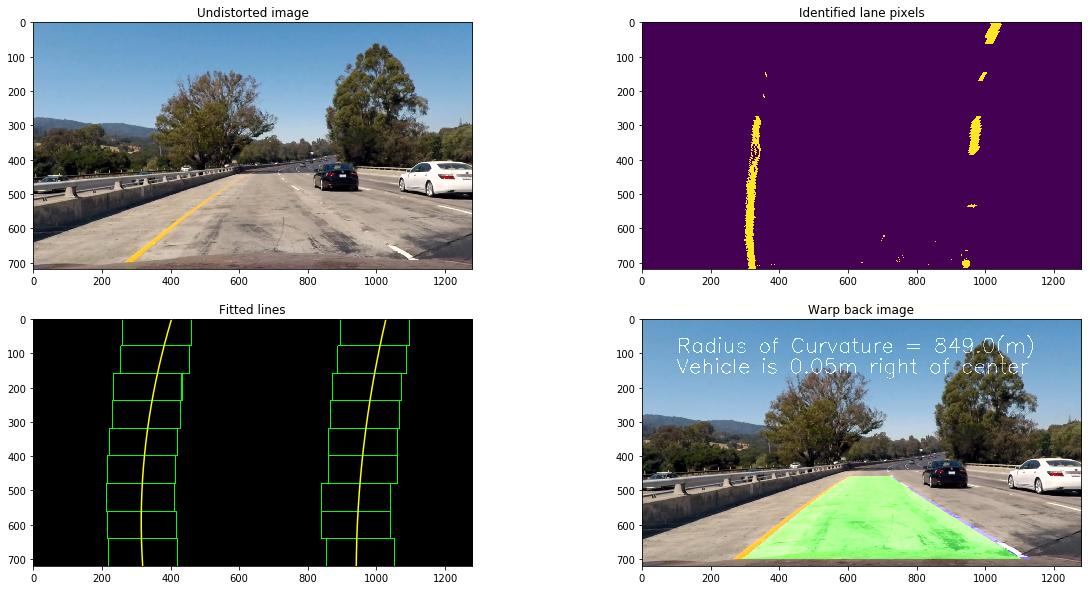

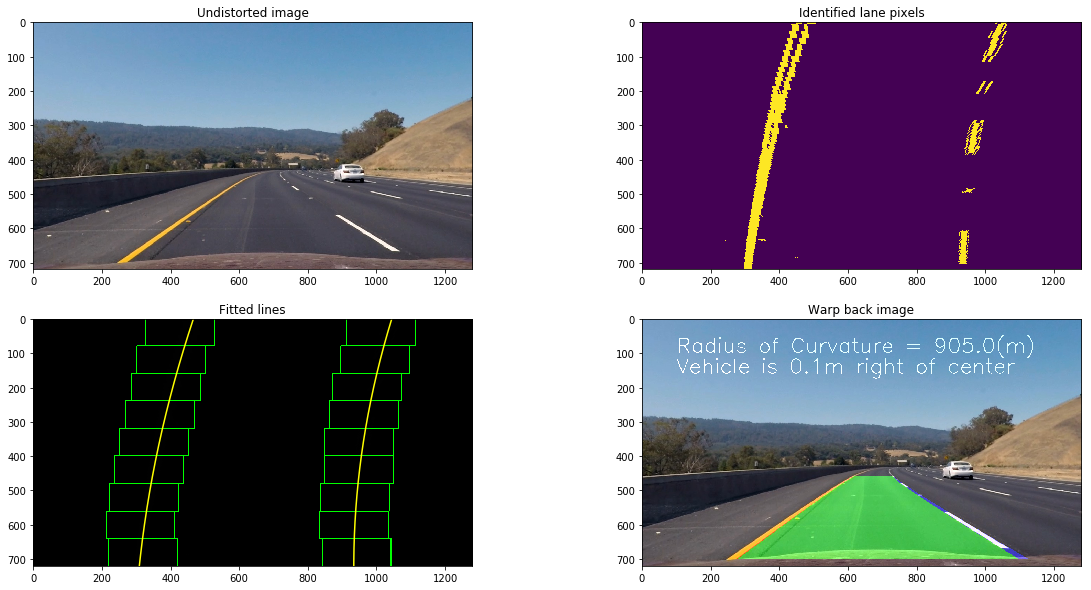

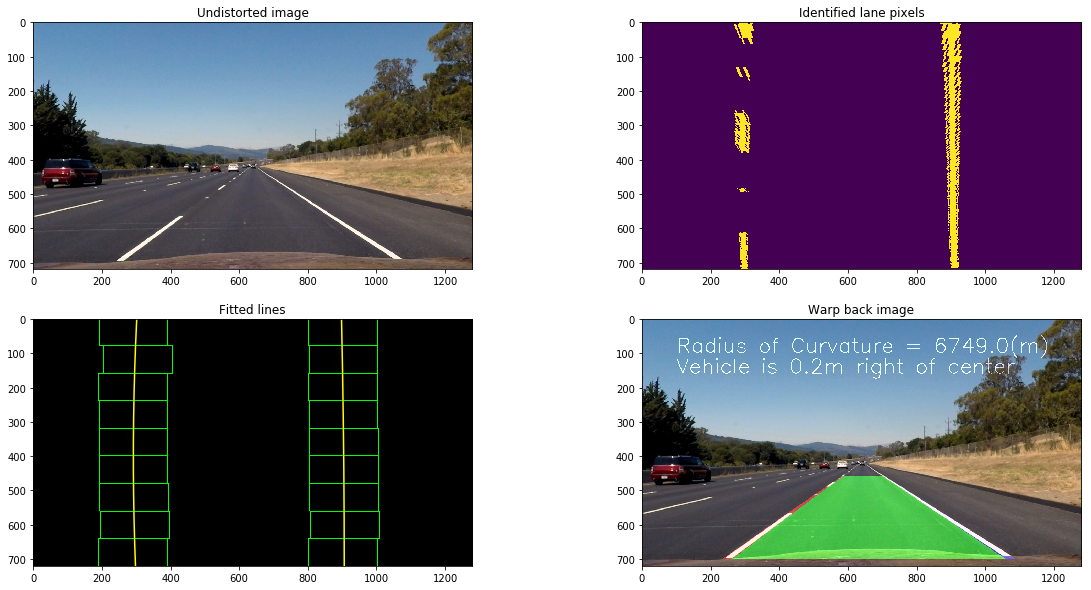

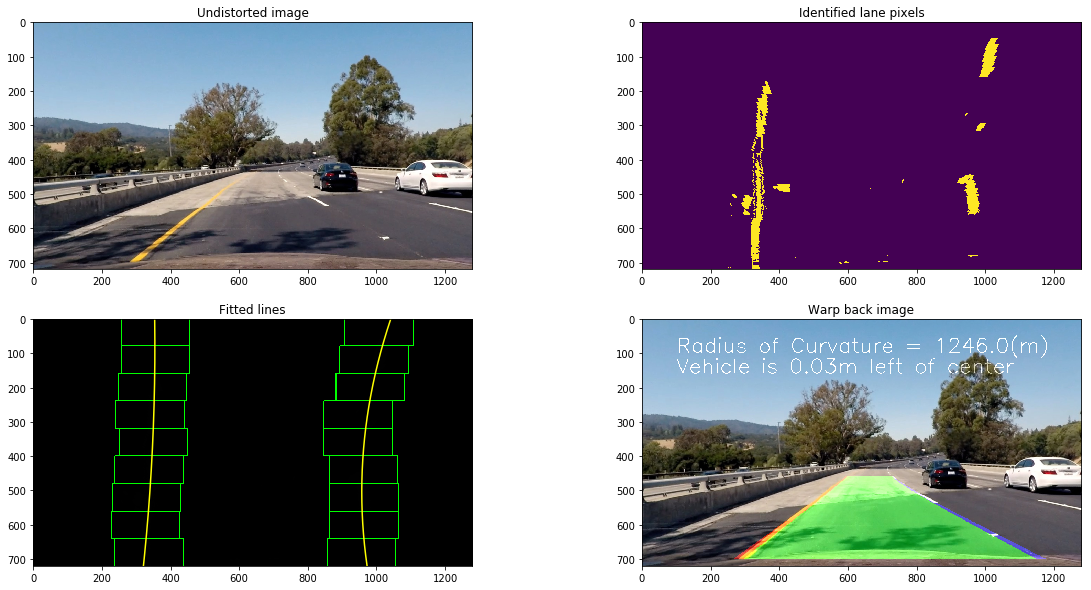

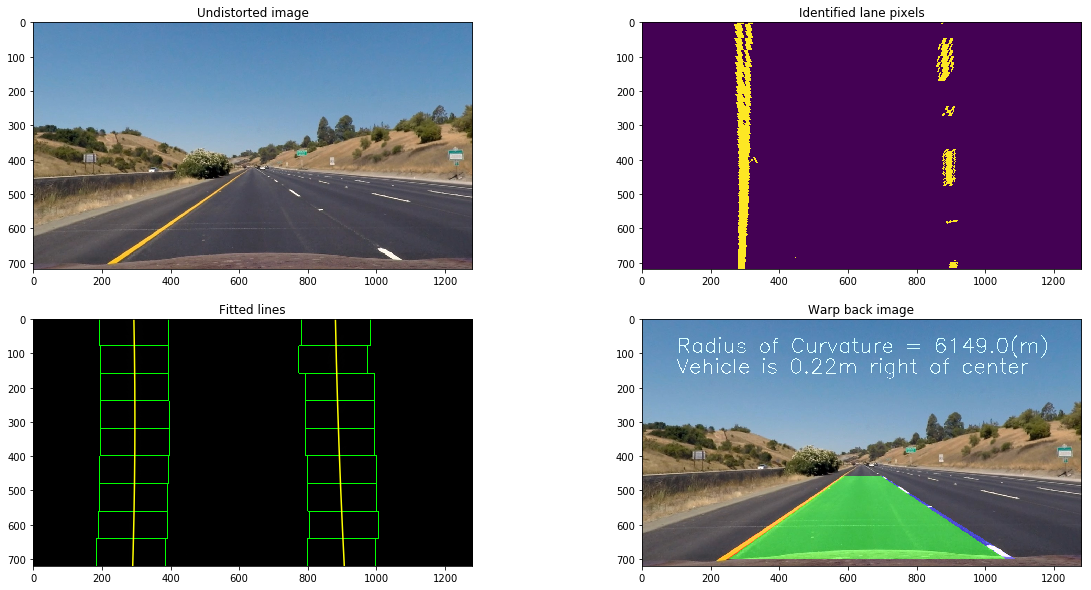

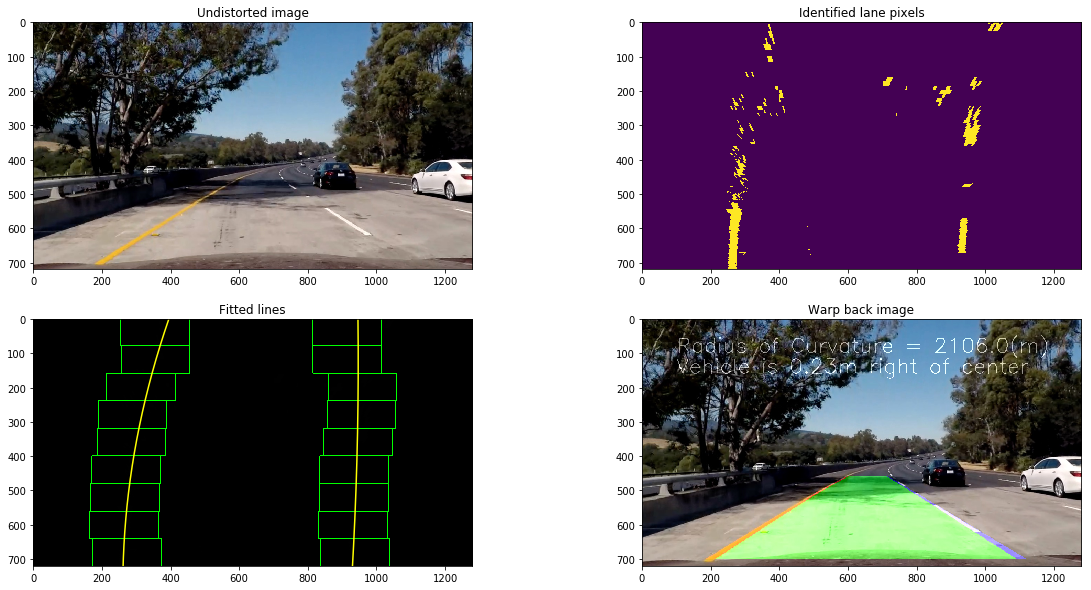

IsADirectoryError: [Errno 21] Is a directory: './test_images/.ipynb_checkpoints'

In [13]:
import os
os.listdir("./test_images/")
test_images = ['./test_images/{}'.format(filename) for filename in os.listdir("./test_images/")]

for image_name in test_images:
    pipeline(image_name, True)
    #mpimg.imsave(image_name, rst)

### Skip the search once the line has been identified, in the next frame just search the pixels with x-values that are +/- your margin from your polynomial lines

In [14]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

In [15]:
def search_around_poly(dst, binary_warped, left_fit, right_fit, visualization=False):
    # HYPERPARAMETER
    # 
    # 
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    warped = process_warped(dst, left_fitx, right_fitx, ploty)
    unwarped = unwarper(warped)

    
    # Conversion to world space and write text
    msg1, msg2 = conversion_to_world_space(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty, ploty)
    unwarped = write_text(unwarped, msg1, msg2)
    rst = cv2.addWeighted(dst, 1., unwarped, 0.5, 0)
    
    #Visualization
    if visualization:
        plt.figure(figsize=(20,10))
        plt.subplot(121),plt.imshow(binary_warped)
        plt.title('Original Image')
        plt.subplot(122),plt.imshow(rst)
        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        plt.title('Processed Image')
        plt.show()
    
    return rst, left_fit, right_fit

In [16]:
def process_image(image):
    global first, left_fit, right_fit
    if first:
        rst, left_fit, right_fit = pipeline(image)
        #first = False
    else:
        dst, binary_warped = binary_warper(image)
        rst, left_fit, right_fit = search_around_poly(dst, binary_warped, left_fit, right_fit)
        
    return rst

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip1 = VideoFileClip("./project_video.mp4")

frame1 = clip1.get_frame(0)
frame2 = clip1.get_frame(1)

In [18]:
#import moviepy.video.io.ImageSequenceClip

# clip1 = VideoFileClip("./project_video.mp4")
# getting number of frames 
# n_frames = sum(1 for x in clip1.iter_frames())

# getting frame rate of the clip 
# rate = clip1.fps 

In [19]:
#image_files = []
#for i in range(n_frames):
#    frame = clip1.get_frame(i)
#    if i==1: #identify the line
#        rst, left_fit, right_fit = pipeline(frame)       
#    else: #search around poly
#        dst, binary_warped = binary_warper(frame)
#        rst, left_fit, right_fit = search_around_poly(dst, binary_warped, left_fit, right_fit)
#    image_files.append(rst)

#clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=25)
#clip.write_videofile('./test_videos/project_video.mp4', audio=False) 

In [20]:
first = True
left_fit = None
right_fit = None

clip = clip1.fl_image(process_image)
%time clip.write_videofile('./output_videos/project_video.mp4', audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [04:51<00:00,  4.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

CPU times: user 2min 31s, sys: 10.9 s, total: 2min 42s
Wall time: 4min 54s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_videos/project_video.mp4'))

In [22]:
clip2 = VideoFileClip("./challenge_video.mp4")
#n_frames = sum(1 for x in clip2.iter_frames())
# getting frame rate of the clip 
#rate = clip1.fps 

#print (n_frames, rate)

In [23]:
first = True
left_fit = None
right_fit = None

clip = clip2.fl_image(process_image)
clip.write_videofile('./output_videos/challenge_video_4.mp4', audio=False)

[MoviePy] >>>> Building video ./output_videos/challenge_video_4.mp4
[MoviePy] Writing video ./output_videos/challenge_video_4.mp4


100%|██████████| 485/485 [01:48<00:00,  4.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video_4.mp4 

